In [7]:
%matplotlib inline



Postprocessing Tutorial
=======================

Spike sorters generally output a set of units with corresponding spike trains. The :code:`toolkit.postprocessing`
submodule allows to combine the :code:`RecordingExtractor` and the sorted :code:`SortingExtractor` objects to perform
further postprocessing.



In [2]:
import matplotlib.pylab as plt

import spikeinterface.extractors as se
import spikeinterface.toolkit as st

First, let's create a toy example:



In [3]:
recording, sorting = se.example_datasets.toy_example(num_channels=4, duration=10, seed=0)

Assuming the :code:`sorting` is the output of a spike sorter, the
:code:`postprocessing` module allows to extract all relevant information
from the paired recording-sorting.



Compute spike waveforms
--------------------------

Waveforms are extracted with the :code:`get_unit_waveforms` function by
extracting snippets of the recordings when spikes are detected. When
waveforms are extracted, the can be loaded in the :code:`SortingExtractor`
object as features. The ms before and after the spike event can be
chosen. Waveforms are returned as a list of np.arrays (n\_spikes,
n\_channels, n\_points)



In [4]:
wf = st.postprocessing.get_unit_waveforms(recording, sorting, ms_before=1, ms_after=2,
                                          save_as_features=True, verbose=True)

Waveform 1/10
Waveform 2/10
Waveform 3/10
Waveform 4/10
Waveform 5/10
Waveform 6/10
Waveform 7/10
Waveform 8/10
Waveform 9/10
Waveform 10/10


Now :code:`waveforms` is a unit spike feature!



In [5]:
print(sorting.get_shared_unit_spike_feature_names())
print(wf[0].shape)

['waveforms']
(21, 4, 90)


plotting waveforms of units 0,1,2 on channel 0



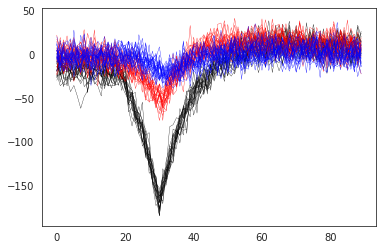

In [9]:
fig, ax = plt.subplots()
ax.plot(wf[0][:, 0, :].T, color='k', lw=0.3)
ax.plot(wf[1][:, 0, :].T, color='r', lw=0.3)
_=ax.plot(wf[2][:, 0, :].T, color='b', lw=0.3)

If the a certain property (e.g. :code:`group`) is present in the
 RecordingExtractor, the waveforms can be extracted only on the channels
 with that property using the :code:`grouping_property` and
 :code:`compute_property_from_recording` arguments. For example, if channel
 [0,1] are in group 0 and channel [2,3] are in group 2, then if the peak
 of the waveforms is in channel [0,1] it will be assigned to group 0 and
 will have 2 channels and the same for group 1.



In [10]:
channel_groups = [[0, 1], [2, 3]]
for ch in recording.get_channel_ids():
    for gr, channel_group in enumerate(channel_groups):
        if ch in channel_group:
            recording.set_channel_property(ch, 'group', gr)
print(recording.get_channel_property(0, 'group'), recording.get_channel_property(2, 'group'))

0 1


In [11]:
wf_by_group = st.postprocessing.get_unit_waveforms(recording, sorting, ms_before=1, ms_after=2,
                                                   save_as_features=False, verbose=True,
                                                   grouping_property='group',
                                                   compute_property_from_recording=True)

# now waveforms will only have 2 channels
print(wf_by_group[0].shape)

Waveforms by property:  group
Waveform 1/10
Waveform 2/10
Waveform 3/10
Waveform 4/10
Waveform 5/10
Waveform 6/10
Waveform 7/10
Waveform 8/10
Waveform 9/10
Waveform 10/10
(21, 2, 90)


Compute unit templates
--------------------------
 
 Similarly to waveforms, templates - average waveforms - can be easily
 extracted using the :code:`get_unit_templates`. When spike trains have
 numerous spikes, you can set the :code:`max_spikes_per_unit` to be extracted.
 If waveforms have already been computed and stored as :code:`features`, those
 will be used. Templates can be saved as unit properties.



In [12]:
templates = st.postprocessing.get_unit_templates(recording, sorting, max_spikes_per_unit=200,
                                                 save_as_property=True, verbose=True)

In [13]:
print(sorting.get_shared_unit_property_names())

['template']


Plotting templates of units 0,1,2 on all four channels



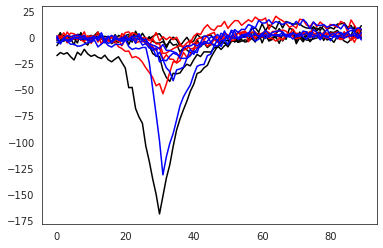

In [14]:
fig, ax = plt.subplots()
ax.plot(templates[0].T, color='k')
ax.plot(templates[1].T, color='r')
ax.plot(templates[2].T, color='b')

Compute unit maximum channel
 -------------------------------
 
 In the same way, one can get the ecording channel with the maximum
 amplitude and save it as a property.



In [15]:
max_chan = st.postprocessing.get_unit_max_channels(recording, sorting, save_as_property=True, verbose=True)
print(max_chan)

[0, 0, 1, 1, 1, 2, 2, 2, 2, 3]


In [16]:
print(sorting.get_shared_unit_property_names())

['max_channel', 'template']


Compute pca scores
 ---------------------
 
 For some applications, for example validating the spike sorting output,
 PCA scores can be computed.



Using 'waveforms' features
Fitting PCA of 3 dimensions on 237 waveforms
(21, 3)
(24, 3)
(25, 3)
(26, 3)
(26, 3)
(22, 3)
(20, 3)
(26, 3)
(22, 3)
(25, 3)


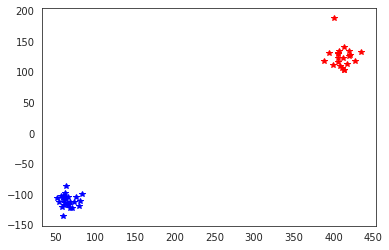

In [17]:
pca_scores = st.postprocessing.compute_unit_pca_scores(recording, sorting, n_comp=3, verbose=True)

for pc in pca_scores:
    print(pc.shape)

fig, ax = plt.subplots()
ax.plot(pca_scores[0][:, 0], pca_scores[0][:, 1], 'r*')
ax.plot(pca_scores[2][:, 0], pca_scores[2][:, 1], 'b*')

PCA scores can be also computed electrode-wise. In the previous example,
 PCA was applied to the concatenation of the waveforms over channels.



In [18]:
pca_scores_by_electrode = st.postprocessing.compute_unit_pca_scores(recording, sorting, n_comp=3, by_electrode=True)

for pc in pca_scores_by_electrode:
    print(pc.shape)

(21, 4, 3)
(24, 4, 3)
(25, 4, 3)
(26, 4, 3)
(26, 4, 3)
(22, 4, 3)
(20, 4, 3)
(26, 4, 3)
(22, 4, 3)
(25, 4, 3)


In this case, as expected, 3 principal components are extracted for each
 electrode.



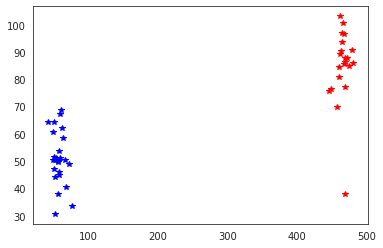

In [19]:
fig, ax = plt.subplots()
ax.plot(pca_scores_by_electrode[0][:, 0, 0], pca_scores_by_electrode[0][:, 1, 0], 'r*')
ax.plot(pca_scores_by_electrode[2][:, 0, 0], pca_scores_by_electrode[2][:, 1, 1], 'b*')

Export sorted data to Phy for manual curation
-----------------------------------------------
 
 Finally, it is common to visualize and manually curate the data after
 spike sorting. In order to do so, we interface wiht the Phy
 (https://phy-contrib.readthedocs.io/en/latest/template-gui/).
 
 First, we need to export the data to the phy format:



In [20]:
st.postprocessing.export_to_phy(recording, sorting, output_folder='phy', verbose=True)

Waveform 1/10
Waveform 2/10
Waveform 3/10
Waveform 4/10
Waveform 5/10
Waveform 6/10
Waveform 7/10
Waveform 8/10
Waveform 9/10
Waveform 10/10
Computing waveforms
Waveform 1/10
Waveform 2/10
Waveform 3/10
Waveform 4/10
Waveform 5/10
Waveform 6/10
Waveform 7/10
Waveform 8/10
Waveform 9/10
Waveform 10/10
Fitting PCA of 3 dimensions on 948 waveforms
Saved phy format to:  /home/alexgonzalez/Documents/TreeMazeAnalyses/Notebooks/spikeinterface_examples/phy
Run:

phy template-gui  /home/alexgonzalez/Documents/TreeMazeAnalyses/Notebooks/spikeinterface_examples/phy/params.py


In [22]:
!phy template-gui /home/alexgonzalez/Documents/TreeMazeAnalyses/Notebooks/spikeinterface_examples/phy/params.py

Traceback (most recent call last):
  File "/home/alexgonzalez/anaconda3/envs/spk/bin/phy", line 11, in <module>
    load_entry_point('phy', 'console_scripts', 'phy')()
  File "/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/pkg_resources/__init__.py", line 490, in load_entry_point
    return get_distribution(dist).load_entry_point(group, name)
  File "/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/pkg_resources/__init__.py", line 2854, in load_entry_point
    return ep.load()
  File "/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/pkg_resources/__init__.py", line 2445, in load
    return self.resolve()
  File "/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/pkg_resources/__init__.py", line 2451, in resolve
    module = __import__(self.module_name, fromlist=['__name__'], level=0)
  File "/home/alexgonzalez/Documents/TreeMazeAnalyses/Lib/phy/phy/apps/__init__.py", line 22, in <module>
    from phy.gui.qt import QtDi

To run phy you can then run (from terminal):
 :code:`phy template-gui phy/params.py`
 
 Or from a notebook:  :code:`!phy template-gui phy/params.py`

 After manual curation you can load back the curated data using the :code:`PhySortingExtractor`:

